<a href="https://colab.research.google.com/github/iusami/bayes_ml/blob/master/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#moduleの準備
!pip install numpyro japanize-matplotlib

In [27]:
import japanize_matplotlib
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

## 一様分布とベータ分布からサンプリング

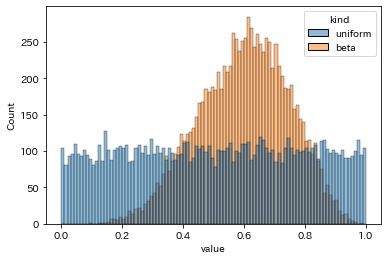

In [28]:
from jax.random import PRNGKey
from numpyro.distributions import Uniform, Beta
#keyの準備
key = PRNGKey(seed=1234)

#一様分布とベータ分布からのサンプリング
uni = Uniform()
beta = Beta(concentration0=4, concentration1=6)
uniform_sample = uni.sample(key, sample_shape=(10000,))
beta_sample = beta.sample(key, sample_shape=(10000,))
uniform_df = pd.DataFrame({"value":uniform_sample, "kind":"uniform"})
beta_df = pd.DataFrame({"value":(beta_sample), "kind":"beta"})
sample_df = pd.concat([uniform_df, beta_df], axis=0).reset_index(drop=True)

#seabornで可視化
sns.histplot(data=sample_df,x="value", hue="kind", bins=100,binrange=(0,1))

## ベータ分布の事後分布の計算

データがベルヌーイ分布から生成されたとして、事前分布をベータ分布
$$p(x|\alpha,\beta) = \cfrac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha,\beta)}$$
とする。  
その時事後分布は以下のようにかける。

$$p(q|D) = \cfrac{q^{\alpha_\ast-1}(1-q)^{\beta_\ast-1}}{B(\alpha_\ast,\  \beta_\ast)}, \alpha_\ast=y+\alpha, \beta_\ast=n-y+\beta, y=\sum_{i=1}^{n}x_i   $$ 
ただし、$n$はサンプルサイズ。

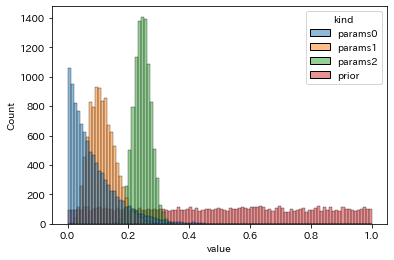

In [29]:
from numpyro.distributions import BernoulliProbs
bern = BernoulliProbs(0.25)
#データの準備
n = [10,50,250]
bern_sample = [bern.sample(key, sample_shape=(i,)) for i in n]

#事後分布の計算関数の準備
def beta_posterior_parameter(alpha, beta, sample):
  y = np.sum(sample)
  alpha_ast = y + alpha
  beta_ast = len(sample) - y + beta
  return alpha_ast, beta_ast

alpha0=1
beta0=1

post_params = [beta_posterior_parameter(alpha0, beta0, np.array(i)) for i in bern_sample]

#生成したサンプルごとの事後分布の計算
beta_posterior_samples = []
for ct, params in enumerate(post_params):
  alpha_curr, beta_curr = params
  beta_post = Beta(alpha_curr, beta_curr)
  sample_df_tmp = pd.DataFrame({"value":np.array(beta_post.sample(key, sample_shape=(10000,))), "kind":"params{}".format(str(ct))})
  beta_posterior_samples.append(sample_df_tmp)
beta_posterior_samples_df = pd.concat(beta_posterior_samples).reset_index(drop=True)

#事前分布のサンプル
beta_pre = Beta(alpha0, beta0)
beta_pre_sample = np.array(beta_pre.sample(key, sample_shape=(10000,)))
beta_pre_sample_df = pd.DataFrame({"value":beta_pre_sample,"kind":"prior"})

concat_df = pd.concat([beta_posterior_samples_df, beta_pre_sample_df]).reset_index(drop=True)

#seabornで可視化
sns.histplot(concat_df, x="value", hue="kind", bins=100,binrange=(0,1))

In [30]:
#事前分布の変更

In [32]:
alpha1=6
beta1=4
post_params = [beta_posterior_parameter(alpha1, beta1, np.array(i)) for i in bern_sample]
beta_posterior_samples = []
for ct, params in enumerate(post_params):
  alpha_curr, beta_curr = params
  beta_post = Beta(alpha_curr, beta_curr)
  sample_df_tmp = pd.DataFrame({"value":np.array(beta_post.sample(key, sample_shape=(10000,))), "kind":"params{}".format(str(ct))})
  beta_posterior_samples.append(sample_df_tmp)
beta_posterior_samples_df = pd.concat(beta_posterior_samples).reset_index(drop=True)
#事前分布のサンプル
beta_pre = Beta(alpha1, beta1)
beta_pre_sample = np.array(beta_pre.sample(key, sample_shape=(10000,)))
beta_pre_sample_df = pd.DataFrame({"value":beta_pre_sample,"kind":"prior"})
concat_df_2 = pd.concat([beta_posterior_samples_df, beta_pre_sample_df]).reset_index(drop=True)

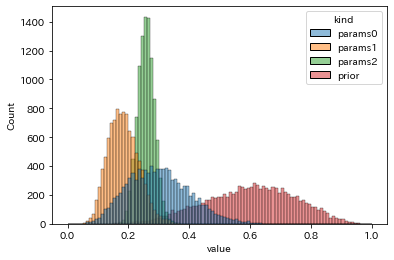

In [33]:
sns.histplot(concat_df_2, x="value", hue="kind", bins=100,binrange=(0,1))

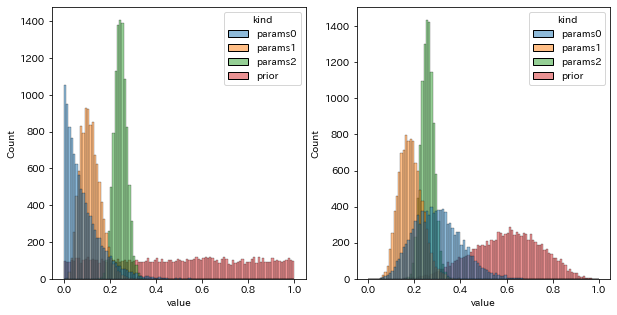

In [34]:
#事前分布の影響の比較
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(concat_df, x="value", hue="kind", bins=100,binrange=(0,1), ax=ax[0])
sns.histplot(concat_df_2, x="value", hue="kind", bins=100,binrange=(0,1), ax=ax[1])

In [35]:
#HPD区間の表示

In [36]:
from numpyro.diagnostics import summary

In [37]:
beta_hpd = Beta(6,4)
beta_hpd_sample = beta_hpd.sample(key, sample_shape=(10000,))
summary_res = summary(beta_hpd_sample,group_by_chain=False)
summary_df = pd.DataFrame(summary_res)
summary_df.columns=["値"]

In [38]:
summary_df

,値
5.0%,0.365745
95.0%,0.850152
mean,0.599876
median,0.608533
n_eff,9889.899876
r_hat,0.999914
std,0.147820


(0.0, 1500.0)

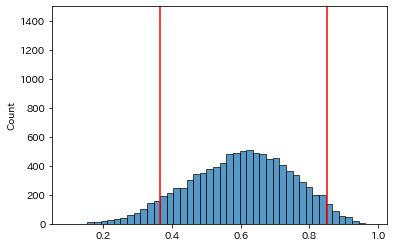

In [39]:
sns.histplot(beta_hpd_sample)
plt.vlines(summary_res["Param:0"]["5.0%"],0,10000,color="red")
plt.vlines(summary_res["Param:0"]["95.0%"],0,10000,color="red")
plt.ylim(0,1500)

In [40]:
#事後分布についてのsummary

In [41]:
post_beta_summary = Beta(post_params[2][0], post_params[2][1])

In [42]:
post_beta_summary_sample = post_beta_summary.sample(key, (10000,))
summary(post_beta_summary_sample,0.9,False)

{'Param:0': OrderedDict([('mean', 0.2577526),
              ('std', 0.027135147),
              ('median', 0.25745842),
              ('5.0%', 0.21162954),
              ('95.0%', 0.30036533),
              ('n_eff', 9944.387102027846),
              ('r_hat', 1.0000194114965053)])}

In [43]:
#事後確率の計算
beta_post = Beta(post_params[2][0],post_params[2][1])
q = 0.3

#30%以上であるという仮説
print("事後確率による結果:",1 - beta_post.cdf(q))

#事後オッズ比の計算
odds = (1 - beta_post.cdf(q))/beta_post.cdf(q)
print("事後オッズ比による結果:",odds)

#ベイズファクターでの比較
pre_odds = (1- beta_pre.cdf(q))/beta_pre.cdf(q)
print("ベイズファクターでの比較:",np.log10(odds/pre_odds))

#SDDRの計算
#30%かどうか
sddr = np.log10(scipy.stats.beta.pdf(0.3, alpha1, beta1)/scipy.stats.beta.pdf(0.3, post_params[2][0], post_params[2][1]))
print("SDDR:",sddr)

#確率変数の予測
a_ast, b_ast = post_params[2]
print("予測した確率変数:",a_ast/(a_ast+b_ast))

事後確率による結果: 0.0627836
事後オッズ比による結果: 0.06698944
ベイズファクターでの比較: -2.7598357
SDDR: -1.0076445793821351
予測した確率変数: 0.25769230769230766
